In [1]:
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.formula.api as smf

In [2]:
# Read in csv file
df = pd.read_csv('GPTarget2024.csv')

In [3]:
# Create new dataframes split by issue
df_digital_privacy = df[df['issue_stance'] == "The U.S. should not implement legislation that strengthens digital privacy rights"]
df_renewable_energy = df[df['issue_stance'] == "The U.S. should increase investments in renewable energy technologies."]
df_china_sanctions = df[df['issue_stance'] == "The U.S. should impose stronger economic sanctions on China."]
df_nato_support = df[df['issue_stance'] == "The U.S. should not increase its support for NATO."]

In [4]:
# Split by political affiliation
df_democrat = df[df['party_affiliation'].isin(['strong_democrat', 'moderate_democrat'])]
df_republican = df[df['party_affiliation'].isin(['strong_republican', 'moderate_republican'])]
df_independent = df[df['party_affiliation'] == 'independent']

df_digital_privacy_democrat = df_digital_privacy[df_digital_privacy['party_affiliation'].isin(['strong_democrat', 'moderate_democrat'])]
df_digital_privacy_republican = df_digital_privacy[df_digital_privacy['party_affiliation'].isin(['strong_republican', 'moderate_republican'])]
df_digital_privacy_independent = df_digital_privacy[df_digital_privacy['party_affiliation'] == 'independent']

df_renewable_energy_democrat = df_renewable_energy[df_renewable_energy['party_affiliation'].isin(['strong_democrat', 'moderate_democrat'])]
df_renewable_energy_republican = df_renewable_energy[df_renewable_energy['party_affiliation'].isin(['strong_republican', 'moderate_republican'])]
df_renewable_energy_independent = df_renewable_energy[df_renewable_energy['party_affiliation'] == 'independent']

df_china_sanctions_democrat = df_china_sanctions[df_china_sanctions['party_affiliation'].isin(['strong_democrat', 'moderate_democrat'])]
df_china_sanctions_republican = df_china_sanctions[df_china_sanctions['party_affiliation'].isin(['strong_republican', 'moderate_republican'])]
df_china_sanctions_independent = df_china_sanctions[df_china_sanctions['party_affiliation'] == 'independent']

df_nato_support_democrat = df_nato_support[df_nato_support['party_affiliation'].isin(['strong_democrat', 'moderate_democrat'])]
df_nato_support_republican = df_nato_support[df_nato_support['party_affiliation'].isin(['strong_republican', 'moderate_republican'])]
df_nato_support_independent = df_nato_support[df_nato_support['party_affiliation'] == 'independent']

In [5]:
# Define the issues, political affiliations, and a category for all issues
issues = ['digital_privacy', 'renewable_energy', 'china_sanctions', 'nato_support']
political_affiliations = ['democrat', 'republican', 'independent']

# Dictionary to hold the models and results
models = {}
results = {}

# Loop over each issue and political affiliation to create and fit the models
for issue in issues:
    for affiliation in political_affiliations:
        df_name = f'df_{issue}_{affiliation}'
        
        # Access the dataframe from the locals() dictionary
        df = locals()[df_name]
        
        # Define the formula
        formula = 'dv_response_mean ~ Q("microtargeting") + Q("false microtargeting") + Q("no microtargeting") + political_party_coded + political_ideology_coded + political_engagement_coded'
        
        # Create and fit the model
        models[df_name] = smf.ols(formula=formula, data=df)
        results[df_name] = models[df_name].fit()

# Now you can access each result using the results dictionary
# For example, to access the result for digital privacy for democrats:
result_digital_privacy_democrat = results['df_digital_privacy_democrat']
result_digital_privacy_republican = results['df_digital_privacy_republican']
result_digital_privacy_independent = results['df_digital_privacy_independent']
result_renewable_energy_democrat = results['df_renewable_energy_democrat']
result_renewable_energy_republican = results['df_renewable_energy_republican']
result_renewable_energy_independent = results['df_renewable_energy_independent']
result_china_sanctions_democrat = results['df_china_sanctions_democrat']
result_china_sanctions_republican = results['df_china_sanctions_republican']
result_china_sanctions_independent = results['df_china_sanctions_independent']
result_nato_support_democrat = results['df_nato_support_democrat']
result_nato_support_republican = results['df_nato_support_republican']
result_nato_support_independent = results['df_nato_support_independent']

In [6]:
# Create a dataframe to store the results for plotting
issues_models = {
    'Digital Privacy Democrat': results['df_digital_privacy_democrat'],
    'Digital Privacy Republican': results['df_digital_privacy_republican'],
    'Digital Privacy Independent': results['df_digital_privacy_independent'],
    'Renewable Energy Democrat': results['df_renewable_energy_democrat'],
    'Renewable Energy Republican': results['df_renewable_energy_republican'],
    'Renewable Energy Independent': results['df_renewable_energy_independent'],
    'China Sanctions Democrat': results['df_china_sanctions_democrat'],
    'China Sanctions Republican': results['df_china_sanctions_republican'],
    'China Sanctions Independent': results['df_china_sanctions_independent'],
    'NATO Support Democrat': results['df_nato_support_democrat'],
    'NATO Support Republican': results['df_nato_support_republican'],
    'NATO Support Independent': results['df_nato_support_independent']
}

# Initialize an empty list to store the data
data = []

# Iterate over the dictionary to extract the data
for issue, model in issues_models.items():
    # Extract the coefficients and the confidence intervals
    coef = model.params
    conf_int = model.conf_int()
    
    # Determine the political affiliation from the issue key
    if 'Democrat' in issue:
        affiliation = 'Democrat'
    elif 'Republican' in issue:
        affiliation = 'Republican'
    else:
        affiliation = 'Independent'
    
    # Iterate over the coefficients
    for covariate in ['microtargeting', 'false microtargeting', 'no microtargeting']:
        # Use the Q function label format
        q_covariate = f'Q("{covariate}")'
        # Skip if the covariate is not in the model
        if q_covariate not in coef:
            continue
        # Get the coefficient and confidence interval
        coefficient = coef[q_covariate]
        lower_ci, upper_ci = conf_int.loc[q_covariate]
        
        # Append the data to the list
        data.append({
            'Covariate': covariate,
            'Issue': issue.replace(' ', '_'),
            'Affiliation': affiliation,
            'Coefficient': coefficient,
            '95% CI Lower': lower_ci,
            '95% CI Upper': upper_ci
        })

# Create a DataFrame from the list
results_df = pd.DataFrame(data)

In [7]:
def compute_weighted_stats(term, models):
    coefficients = np.array([model.params[term] for model in models])
    standard_errors = np.array([model.bse[term] for model in models])

    weights = 1 / standard_errors**2
    weighted_mean = np.sum(coefficients * weights) / np.sum(weights)
    weighted_variance = 1 / np.sum(weights)
    weighted_std_error = np.sqrt(weighted_variance)

    z_critical = scipy.stats.norm.ppf(0.975)  # 97.5th percentile for two-tailed test
    confidence_interval = (weighted_mean - z_critical * weighted_std_error, 
                           weighted_mean + z_critical * weighted_std_error)

    return weighted_mean, confidence_interval

# Separate the models by political affiliation
democrat_models = [results['df_digital_privacy_democrat'], results['df_renewable_energy_democrat'], results['df_china_sanctions_democrat'], results['df_nato_support_democrat']]
republican_models = [results['df_digital_privacy_republican'], results['df_renewable_energy_republican'], results['df_china_sanctions_republican'], results['df_nato_support_republican']]
independent_models = [results['df_digital_privacy_independent'], results['df_renewable_energy_independent'], results['df_china_sanctions_independent'], results['df_nato_support_independent']]

# Compute the weighted stats for democrats
microtargeting_mean_democrat, microtargeting_ci_democrat = compute_weighted_stats('Q("microtargeting")', democrat_models)
false_microtargeting_mean_democrat, false_microtargeting_ci_democrat = compute_weighted_stats('Q("false microtargeting")', democrat_models)
no_microtargeting_mean_democrat, no_microtargeting_ci_democrat = compute_weighted_stats('Q("no microtargeting")', democrat_models)

# Compute the weighted stats for republicans
microtargeting_mean_republican, microtargeting_ci_republican = compute_weighted_stats('Q("microtargeting")', republican_models)
false_microtargeting_mean_republican, false_microtargeting_ci_republican = compute_weighted_stats('Q("false microtargeting")', republican_models)
no_microtargeting_mean_republican, no_microtargeting_ci_republican = compute_weighted_stats('Q("no microtargeting")', republican_models)

# Compute the weighted stats for independents
microtargeting_mean_independent, microtargeting_ci_independent = compute_weighted_stats('Q("microtargeting")', independent_models)
false_microtargeting_mean_independent, false_microtargeting_ci_independent = compute_weighted_stats('Q("false microtargeting")', independent_models)
no_microtargeting_mean_independent, no_microtargeting_ci_independent = compute_weighted_stats('Q("no microtargeting")', independent_models)

# Create a list of dictionaries for the new rows, separating by political affiliation
weighted_stats_democrat = [
    {'Covariate': 'microtargeting', 'Issue': 'Precision-weighted mean (Democrat)', 'Affiliation': 'Democrat', 'Coefficient': microtargeting_mean_democrat, '95% CI Lower': microtargeting_ci_democrat[0], '95% CI Upper': microtargeting_ci_democrat[1]},
    {'Covariate': 'false microtargeting', 'Issue': 'Precision-weighted mean (Democrat)', 'Affiliation': 'Democrat', 'Coefficient': false_microtargeting_mean_democrat, '95% CI Lower': false_microtargeting_ci_democrat[0], '95% CI Upper': false_microtargeting_ci_democrat[1]},
    {'Covariate': 'no microtargeting', 'Issue': 'Precision-weighted mean (Democrat)', 'Affiliation': 'Democrat', 'Coefficient': no_microtargeting_mean_democrat, '95% CI Lower': no_microtargeting_ci_democrat[0], '95% CI Upper': no_microtargeting_ci_democrat[1]}
]

weighted_stats_republican = [
    {'Covariate': 'microtargeting', 'Issue': 'Precision-weighted mean (Republican)', 'Affiliation': 'Republican', 'Coefficient': microtargeting_mean_republican, '95% CI Lower': microtargeting_ci_republican[0], '95% CI Upper': microtargeting_ci_republican[1]},
    {'Covariate': 'false microtargeting', 'Issue': 'Precision-weighted mean (Republican)', 'Affiliation': 'Republican', 'Coefficient': false_microtargeting_mean_republican, '95% CI Lower': false_microtargeting_ci_republican[0], '95% CI Upper': false_microtargeting_ci_republican[1]},
    {'Covariate': 'no microtargeting', 'Issue': 'Precision-weighted mean (Republican)', 'Affiliation': 'Republican', 'Coefficient': no_microtargeting_mean_republican, '95% CI Lower': no_microtargeting_ci_republican[0], '95% CI Upper': no_microtargeting_ci_republican[1]}
]

weighted_stats_independent = [
    {'Covariate': 'microtargeting', 'Issue': 'Precision-weighted mean (Independent)', 'Affiliation': 'Independent', 'Coefficient': microtargeting_mean_independent, '95% CI Lower': microtargeting_ci_independent[0], '95% CI Upper': microtargeting_ci_independent[1]},
    {'Covariate': 'false microtargeting', 'Issue': 'Precision-weighted mean (Independent)', 'Affiliation': 'Independent', 'Coefficient': false_microtargeting_mean_independent, '95% CI Lower': false_microtargeting_ci_independent[0], '95% CI Upper': false_microtargeting_ci_independent[1]},
    {'Covariate': 'no microtargeting', 'Issue': 'Precision-weighted mean (Independent)', 'Affiliation': 'Independent', 'Coefficient': no_microtargeting_mean_independent, '95% CI Lower': no_microtargeting_ci_independent[0], '95% CI Upper': no_microtargeting_ci_independent[1]}
]

# Convert the lists of dictionaries to DataFrames
weighted_stats_democrat_df = pd.DataFrame(weighted_stats_democrat)
weighted_stats_republican_df = pd.DataFrame(weighted_stats_republican)
weighted_stats_independent_df = pd.DataFrame(weighted_stats_independent)

# Append the new DataFrames to the existing results_df
results_df = pd.concat([results_df, weighted_stats_democrat_df, weighted_stats_republican_df, weighted_stats_independent_df], ignore_index=True)


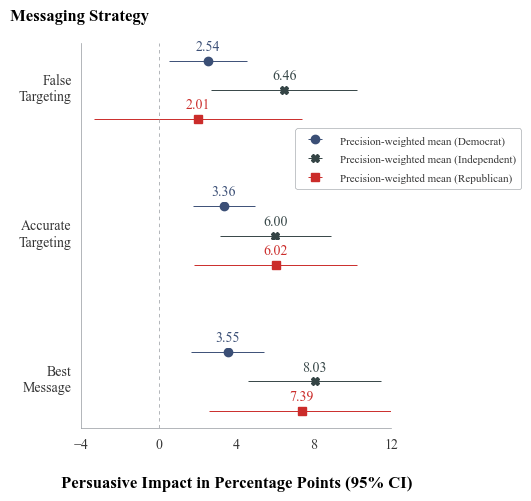

In [8]:
#FIGURE 1 (political party)
# Set the font to "Times New Roman"
plt.rcParams["font.family"] = "Times New Roman"

# Define constants based on results_df
ISSUES = ["Precision-weighted mean (Democrat)", "Precision-weighted mean (Independent)", "Precision-weighted mean (Republican)"]
NEW_LABELS = ['no microtargeting', 'microtargeting', 'false microtargeting']
COLOR_MAP = ['#3b4f76', '#354546', '#CB2C2A']
MARKERS = ['o', 'X', 's']

# Set the plot dimensions
fig, ax = plt.subplots(figsize=(4,5))

# Initialize y_pos array for the base position of the first issue
base_y_pos = np.arange(len(NEW_LABELS), dtype=float)

# The vertical offset to apply for each subsequent issue
vertical_offset = 0.2  # Adjust as needed for spacing

# Iterate over the unique issues
for idx, (issue, color, marker) in enumerate(zip(ISSUES, COLOR_MAP, MARKERS)):
    # Calculate the y_pos for the current issue with an offset
    y_pos = base_y_pos - idx * vertical_offset
    
    # Filter the results_df for the current issue
    issue_data = results_df[results_df['Issue'] == issue]
    
    # Initialize a variable to control the addition of the label to the legend
    added_label = False
    
    # Set the line width based on the issue
    line_width = 0.7 if issue != "Precision-weighted mean" else 2
    
    # Iterate over the unique covariates
    for i, covariate in enumerate(NEW_LABELS):
        # Filter the issue_data for the current covariate
        covariate_data = issue_data[issue_data['Covariate'] == covariate]
        
        # Plot coefficients with error bars
        ax.errorbar(covariate_data['Coefficient'], y_pos[i], 
                    xerr=[covariate_data['Coefficient'] - covariate_data['95% CI Lower'], 
                          covariate_data['95% CI Upper'] - covariate_data['Coefficient']], 
                    fmt=marker, color=color, ecolor=color, capsize=0, linewidth=line_width,
                    label=issue if not added_label else "")
        
        # Ensure that the label is added only once
        added_label = True
        
        # Add coefficient labels
        ax.text(covariate_data['Coefficient'].values[0], y_pos[i] + 0.1, f"{covariate_data['Coefficient'].values[0]:.2f}", 
                va='center', ha='center', color=color, 
                bbox=dict(facecolor='white', edgecolor='none', pad=2.1))

# Configure the plot
plt.axvline(0, color='#94999E', linestyle='--', linewidth=0.5, dashes=(5, 5))
plt.xlim(-4, 12)

ax.set_xlabel('Persuasive Impact in Percentage Points (95% CI)', fontsize=12, fontweight='bold', labelpad=17)
ax.set_yticks(base_y_pos- 0.17)
ax.set_yticklabels(['Best\nMessage', 'Accurate\nTargeting', 'False\nTargeting'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('#94999E')
ax.spines['bottom'].set_color('#94999E')
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.text(-4.1, len(NEW_LABELS) - .70, 'Messaging Strategy', rotation=0, va='center', ha='center', fontweight='bold', fontsize=12)
ax.tick_params(colors='#333333')
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.tick_params(left=False)
ax.tick_params(bottom=False)

# Configure the legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, loc=(0.69, 0.62), edgecolor='#94999E')
legend.get_frame().set_linewidth(0.5)

for text in legend.get_texts():
    text.set_color('#333333')
    text.set_fontsize(8)

# Display the plot
plt.show()

fig.savefig('figure1_party.pdf', format='pdf', bbox_inches='tight')